In [1]:
import torch 
import numpy as np
import pandas as pd

import jax.random as jrandom

import matplotlib.pyplot as plt


torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

We are going to solve the heat equation with a PINN. Specifically, we solve it for a rectangular domain with the ends being held at a fixed temperature. 

$$
    \nabla^2 u(x, t) = \partial_t u(x, t) \\
    u(0, y, t) = a_1 \\
    u(1, y, t) = a_2 \\
    u(x, 0, t) = u(x, 1, t) = a_1 + x(a_2 - a_1)
$$

In [2]:
def generate_boundary_values(a1, a2, L, W, T, N): 
    """[[x, y, t], u(x, y, t)=u(x, y, 0)]"""
    ts = np.linspace(0, T, N)
    
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    us_x = 5*np.sin(xs / L * 2 * np.pi * 10) + np.linspace(a1, a2, N)
    us_y_left = np.linspace(a1, a1, N)
    us_y_right = np.linspace(a2, a2, N)
    
    x_data_up = np.concatenate([xs.reshape(-1, 1), W*np.ones(N).reshape(-1, 1), us_x.reshape(-1, 1)], axis=1)
    x_data_down = np.concatenate([xs.reshape(-1, 1), np.zeros(N).reshape(-1, 1), us_x.reshape(-1, 1)], axis=1)

    y_data_left = np.concatenate([np.zeros(N).reshape(-1, 1), ys.reshape(-1, 1), us_y_left.reshape(-1, 1)], axis=1)
    y_data_right = np.concatenate([L*np.ones(N).reshape(-1, 1), ys.reshape(-1, 1), us_y_right.reshape(-1, 1)], axis=1)
    
    data_no_time = np.concatenate([x_data_up, x_data_down, y_data_left, y_data_right])
    data = np.concatenate([np.concatenate([data_no_time, ts[i]*np.ones(len(data_no_time)).reshape(-1, 1)], axis=1) for i in range(len(ts))], axis=0)


    return pd.DataFrame(data, columns=["x", "y", "u", "t"])
    
    

def generate_initial_condition(L, W, T, N):
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    XY = np.meshgrid(xs, ys)
    
    ps = np.concatenate([XY[0].flatten().reshape(-1, 1), XY[1].flatten().reshape(-1, 1)], axis=1)
    
    data = np.concatenate([ps, np.zeros(len(ps)).reshape(-1, 1), np.zeros(len(ps)).reshape(-1, 1)], axis=1)
    
    return pd.DataFrame(data, columns=["x", "y", "u", "t"])


def get_collocation_points(L, W, T, N):
    """Uniform sampling of collocation points"""
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    ts = np.linspace(0, T, N)
    XYT = np.meshgrid(xs, ys, ts)
    data = np.concatenate([x.flatten().reshape(-1, 1) for x in XYT], axis=1)
    return pd.DataFrame(data, columns=["x", "y", "t"])



In [10]:
boundary["x"][f]

NameError: name 'f' is not defined

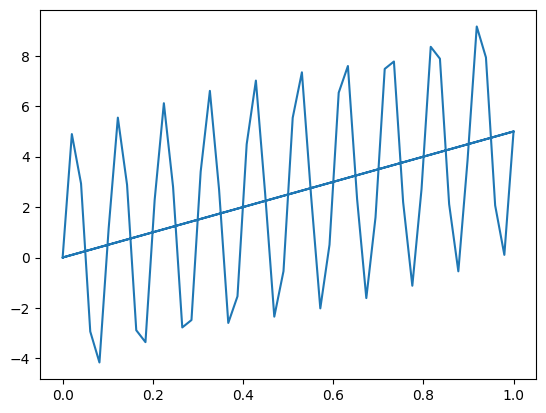

In [11]:
f = (boundary["t"] == 0) & (boundary["y"] == 0)

plt.plot(boundary["x"][f], boundary["u"][f])

In [ ]:
len(boundary)

# Generate boundary data

In [4]:
a1 = 0
a2 = 5
Nb = 50
Ni = 25
W = 1
L = 1

T = 1

boundary = generate_boundary_values(a1, a2, L, W, T, Nb)
initial = generate_initial_condition(L, W, T, Ni)

constraint_points = pd.concat([boundary, initial])



In [5]:
collocation_points = get_collocation_points(L, W, T, 25)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
import torch

import functools
import operator


def grad_getter(inp, out):
    return torch.autograd.grad(inputs=inp, outputs=out, 
                    grad_outputs=torch.ones_like(out),
                    retain_graph=True, create_graph=True
                   )


class SimpleNet(Module):

    def __init__(self, inp_dim, out_dim, width, num_layers):
        super(SimpleNet, self).__init__()

        self.activation_function = torch.tanh

        self.fc_input = nn.Linear(inp_dim, width)
        self.layers = nn.ModuleList([nn.Linear(width, width) for _ in range(num_layers - 1)])
        self.fc_final = nn.Linear(width, out_dim)

    def forward(self, x):
        x = self.activation_function(self.fc_input(x))
        for i in range(len(self.layers)):
            x = self.activation_function(self.layers[i](x))
        x = self.fc_final(x)
        return x

def loss_int(net, X):
    u = net(X)
    x, y, t = X[:, 0], X[:, 1], X[:, 2]

    du_dX = grad_getter(X, u)[0]

    du_dx, du_dy, du_dt = du_dX.T

    du_dxX = grad_getter(X, du_dx)[0]
    du_dxx, du_dxy, du_dxt = du_dxX.T

    du_dyX = grad_getter(X, du_dy)[0]
    du_dyx, du_dyy, du_dyt = du_dyX.T

    Du = du_dxx + du_dyy - du_dt
    return torch.mean(Du**2)

def loss_b(net, X, bs):
    u = net(X).flatten()
    return torch.mean((u - bs)**2)

def loss_closure(net, opt, X, Xb, bs):
    opt.zero_grad()
    X.grad = None
    
    loss = loss_int(net, X) + 100*loss_b(net, Xb, bvs)
    loss.backward()
    print(float(loss))
    return loss

In [8]:
inp_dim = 3
out_dim = 1
width = 64
num_layers = 16
net = SimpleNet(inp_dim, out_dim, width, num_layers)

In [9]:
X = torch.tensor(collocation_points[["x", "y", "t"]].values, requires_grad=True)
Xb, bvs = torch.tensor(constraint_points[["x", "y", "t"]].values), torch.tensor(constraint_points["u"].values)


In [ ]:
optimizer = torch.optim.LBFGS(
            net.parameters(), 
            lr=1, 
            max_iter=5000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )


In [ ]:
optimizer.step(lambda : loss_closure(net, optimizer, X, Xb, bvs))

In [185]:
loss = loss_int(net, X) + loss_b(net, Xb, bvs)

In [186]:
loss_int(net, X)

tensor(0.0052, grad_fn=<DotBackward0>)

In [187]:
loss_b(net, Xb, bvs)

tensor(0.5985, grad_fn=<MeanBackward0>)

In [150]:
net(X)

tensor([[ -6.3398],
        [ -5.2564],
        [ -4.0023],
        ...,
        [107.7641],
        [109.4219],
        [111.0140]], grad_fn=<AddmmBackward0>)

In [106]:
bvs

tensor([10., 20., 30.,  ...,  0.,  0.,  0.])

In [107]:
(net(Xb).flatten() - bvs).shape

torch.Size([1025])

In [215]:
N = 50

xs = np.linspace(0, L, N)
ys = np.linspace(0, W, N)

XY = np.meshgrid(xs, ys)
pts_XY = np.concatenate([x.flatten().reshape(-1, 1) for x in XY], axis=1)
pts = np.concatenate([pts_XY, 0.2*np.ones(len(pts_XY)).reshape(-1, 1)], axis=1)

In [216]:
out = net(torch.tensor(pts))

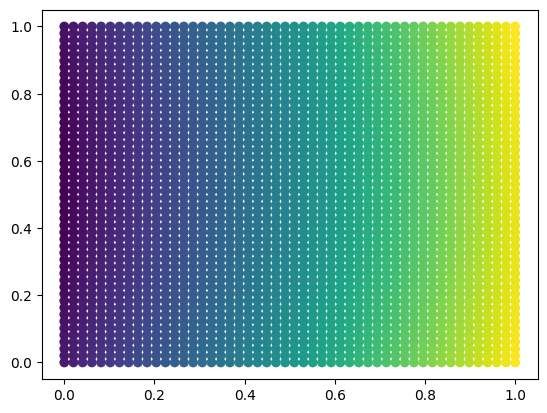

In [217]:
plt.scatter(pts_XY[:, 0], pts_XY[:, 1], c=out.detach().numpy())

In [220]:
inp = torch.tensor(np.concatenate([xs.reshape(-1, 1), np.zeros((len(xs), 1)), 1*np.ones((len(xs), 1))], axis=1))

out = net(inp)

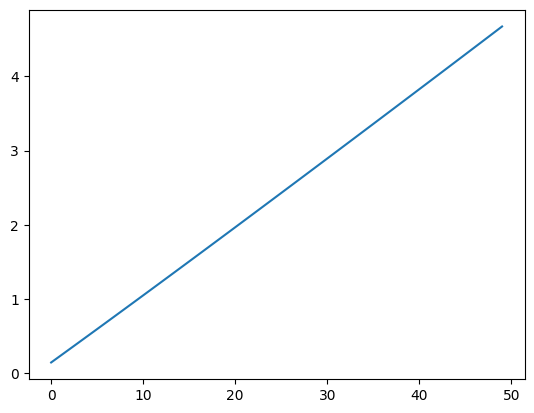

In [221]:
plt.plot(out.detach().numpy())

# Do the same analytically

In [242]:
from scipy.signal import convolve2d

In [249]:
def generate_boundary_values_numerical(a1, a2, L, W, N): 
    
    xs = np.linspace(0, L, N)
    ys = np.linspace(0, W, N)
    
    us_x = 5*np.sin(xs / L * 2 * np.pi * 2) + np.linspace(a1, a2, N)
    us_y_left = np.linspace(a1, a1, N)
    us_y_right = np.linspace(a2, a2, N)
    
    D = np.zeros((N, N))
    D[:, 0] = us_y_left
    D[:, -1] = us_y_right
    
    D[0, :] = us_x
    D[-1, :] = us_x
    return D
    
    

def generate_initial_condition_numerical(L, W, N):
    return np.zeros((N, N))


In [303]:
a1 = 0
a2 = 5
N = 25
W = 1
L = 1
T = 0.1
Nt = 10000

hx = 1/N
ht = T/Nt

boundary = generate_boundary_values_numerical(a1, a2, L, W, N)
initial = generate_initial_condition_numerical(L, W, N)


U_curr = initial + boundary

In [304]:
conv_filter = 1/hx**2 * np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])
res = [U_curr]
for t in range(Nt):
    U_next = U_curr + ht * convolve2d(U_curr, conv_filter, mode='same')
    U_next[:, 0] = 0
    U_next[:, -1] = 0
    U_next[0, :] = 0
    U_next[-1, :] = 0
    U_next += boundary
    
    res.append(U_next)
    U_curr = U_next
    

In [307]:
xs = np.linspace(0, 1, N)
XX = np.meshgrid(xs, xs)

for t in range(0, Nt, 50):

    plt.contourf(XX[0], XX[1], res[t], 20)
    plt.colorbar()
    plt.savefig("figs/{}.png".format(t))
    plt.clf()
    

<Figure size 640x480 with 0 Axes>

In [312]:
import os
os.system("ffmpeg -framerate 30 -pattern_type glob -i 'figs/*.png' \
  -c:v libx264 -pix_fmt yuv420p out.mp4")


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disabl

0